# Legal Case Outcome Prediction - Model Training

This notebook loads, cleans, and trains models on legal case data.


In [1]:
# Fix for importlib metadata issue in conda environments
# This patches both importlib.metadata and importlib_metadata to handle None metadata
import sys
import importlib.metadata
import importlib_metadata

# Patch importlib.metadata.version (used by datasets/config.py)
_original_version = importlib.metadata.version
def _safe_version(name):
    try:
        result = _original_version(name)
        if result is None:
            # Return a valid version string instead of 'unknown'
            return '0.0.0'
        return result
    except Exception:
        # Return a valid version string for packaging.version.parse()
        return '0.0.0'

importlib.metadata.version = _safe_version
sys.modules['importlib.metadata'].version = _safe_version

# Patch importlib_metadata.distribution
_original_distribution = importlib_metadata.distribution
def _safe_distribution(name):
    try:
        dist = _original_distribution(name)
        if hasattr(dist, 'metadata') and dist.metadata is None:
            class MockDist:
                metadata = {'Version': 'unknown'}
                @property
                def version(self):
                    return 'unknown'
            return MockDist()
        return dist
    except Exception:
        class MockDist:
            metadata = {'Version': 'unknown'}
            @property
            def version(self):
                return 'unknown'
        return MockDist()

importlib_metadata.distribution = _safe_distribution
sys.modules['importlib_metadata'].distribution = _safe_distribution

import pandas as pd
import numpy as np
import re
import os
import pickle
from pathlib import Path
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

# Set paths
BASE_DIR = Path('../')
DATA_DIR = BASE_DIR / 'data'
MODELS_DIR = BASE_DIR / 'models'
MODELS_DIR.mkdir(exist_ok=True)

print("Setup complete!")


Setup complete!


## 1. Load CSV Files


In [2]:
# Load both CSV files
dockets = pd.read_csv(DATA_DIR / 'courtlistener_dockets_partial.csv')
opinions = pd.read_csv(DATA_DIR / 'opinions_checkpoint.csv')

print(f"Dockets shape: {dockets.shape}")
print(f"Opinions shape: {opinions.shape}")
print(f"\nDockets columns: {list(dockets.columns)}")
print(f"\nOpinions columns: {list(opinions.columns)}")


Dockets shape: (73000, 58)
Opinions shape: (18500, 8)

Dockets columns: ['resource_uri', 'id', 'court', 'court_id', 'original_court_info', 'idb_data', 'clusters', 'audio_files', 'assigned_to', 'referred_to', 'absolute_url', 'date_created', 'date_modified', 'source', 'appeal_from_str', 'assigned_to_str', 'referred_to_str', 'panel_str', 'date_last_index', 'date_cert_granted', 'date_cert_denied', 'date_argued', 'date_reargued', 'date_reargument_denied', 'date_filed', 'date_terminated', 'date_last_filing', 'case_name_short', 'case_name', 'case_name_full', 'slug', 'docket_number', 'docket_number_core', 'docket_number_raw', 'federal_dn_office_code', 'federal_dn_case_type', 'federal_dn_judge_initials_assigned', 'federal_dn_judge_initials_referred', 'federal_defendant_number', 'pacer_case_id', 'cause', 'nature_of_suit', 'jury_demand', 'jurisdiction_type', 'appellate_fee_status', 'appellate_case_type_information', 'mdl_status', 'filepath_ia', 'filepath_ia_json', 'ia_upload_failure_count', 'ia_n

## 2. Merge Docket and Opinion Data


In [3]:
# Extract docket_id from dockets (it's in the id column)
dockets['docket_id'] = dockets['id'].astype(str)
opinions['docket_id'] = opinions['docket_id'].astype(str)

# Merge on docket_id
df = opinions.merge(
    dockets[['docket_id', 'case_name', 'court']],
    on='docket_id',
    how='inner'
)

print(f"Merged dataset shape: {df.shape}")
print(f"\nMissing values:")
print(df.isnull().sum())
print(f"\nFirst few rows:")
df.head()


Merged dataset shape: (18500, 10)

Missing values:
docket_id           0
case_name_x         0
court_x             0
date_filed      18500
opinion_id          0
opinion_type        0
opinion_text        1
outcome             0
case_name_y         0
court_y             0
dtype: int64

First few rows:


,docket_id,case_name_x,court_x,date_filed,opinion_id,opinion_type,opinion_text,outcome,case_name_y,court_y
0,71884389,Trump v. Orr,https://www.courtlistener.com/api/rest/v4/cour...,NaN,11198703,010combined,Cite as: 607 U. S. ____ (202...,granted,Trump v. Orr,https://www.courtlistener.com/api/rest/v4/cour...
1,71735833,Boyd v. Hamm,https://www.courtlistener.com/api/rest/v4/cour...,NaN,11177002,010combined,...,granted,Boyd v. Hamm,https://www.courtlistener.com/api/rest/v4/cour...
2,71735833,Boyd v. Hamm,https://www.courtlistener.com/api/rest/v4/cour...,NaN,11177003,010combined,Cite as: 607 U. S. ____ (202...,granted,Boyd v. Hamm,https://www.courtlistener.com/api/rest/v4/cour...
3,71735833,Boyd v. Hamm,https://www.courtlistener.com/api/rest/v4/cour...,NaN,11176501,010combined,Cite as: 607 U. S. ____ (202...,granted,Boyd v. Hamm,https://www.courtlistener.com/api/rest/v4/cour...
4,71659774,Crawford v. Mississippi,https://www.courtlistener.com/api/rest/v4/cour...,NaN,11171208,010combined,Cite as: 607 U. S. ____ (202...,denied,Crawford v. Mississippi,https://www.courtlistener.com/api/rest/v4/cour...


## 3. Clean Text Data


In [4]:
def clean_legal_text(text):
    """
    Clean legal text by removing outcome-revealing words and procedural boilerplate.
    Applies tail-scrubbing to last 2000 characters.
    """
    if pd.isna(text) or text == '':
        return ''
    
    text = str(text)
    
    # Outcome-revealing words to remove
    outcome_words = [
        'AFFIRMED', 'REVERSED', 'VACATED', 'REMANDED',
        'GRANTED', 'DISMISSED', 'DENIED',
        'affirmed', 'reversed', 'vacated', 'remanded',
        'granted', 'dismissed', 'denied'
    ]
    
    # Remove outcome words
    for word in outcome_words:
        text = text.replace(word, '')
    
    # Tail-scrubbing: clean last 2000 characters
    if len(text) > 2000:
        tail = text[-2000:]
        main_text = text[:-2000]
        
        # Remove procedural boilerplate patterns from tail
        tail = re.sub(r'Judgment\s+vacated[^.]*\.', '', tail, flags=re.IGNORECASE)
        tail = re.sub(r'and\s+remanded[^.]*\.', '', tail, flags=re.IGNORECASE)
        tail = re.sub(r'Certiorari\s+granted[^.]*\.', '', tail, flags=re.IGNORECASE)
        tail = re.sub(r'The\s+petition\s+for\s+rehearing\s+is\s+denied[^.]*\.', '', tail, flags=re.IGNORECASE)
        tail = re.sub(r'\bremanded\b[^.]*\.', '', tail, flags=re.IGNORECASE)
        tail = re.sub(r'\bvacated\b[^.]*\.', '', tail, flags=re.IGNORECASE)
        tail = re.sub(r'\breversed\b[^.]*\.', '', tail, flags=re.IGNORECASE)
        tail = re.sub(r'\baffirmed\b[^.]*\.', '', tail, flags=re.IGNORECASE)
        
        text = main_text + tail
    else:
        # Apply same cleaning to entire text if shorter than 2000 chars
        text = re.sub(r'Judgment\s+vacated[^.]*\.', '', text, flags=re.IGNORECASE)
        text = re.sub(r'and\s+remanded[^.]*\.', '', text, flags=re.IGNORECASE)
        text = re.sub(r'Certiorari\s+granted[^.]*\.', '', text, flags=re.IGNORECASE)
        text = re.sub(r'The\s+petition\s+for\s+rehearing\s+is\s+denied[^.]*\.', '', text, flags=re.IGNORECASE)
    
    # Clean up extra whitespace
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    
    return text

# Apply cleaning
df['clean_text'] = df['opinion_text'].apply(clean_legal_text)

# Remove rows with empty clean_text
df = df[df['clean_text'].str.len() > 0]

print(f"After cleaning, dataset shape: {df.shape}")
print(f"\nSample cleaned text (first 500 chars):")
print(df['clean_text'].iloc[0][:500] if len(df) > 0 else 'No data')


After cleaning, dataset shape: (18499, 11)

Sample cleaned text (first 500 chars):
Cite as: 607 U. S. ____ (2025) 1 SUPREME COURT OF THE UNITED STATES _________________ No. 25A319 _________________ DONALD J. TRUMP, PRESIDENT OF THE UNITED STATES, ET AL. v. ASHTON ORR, ET AL. ON APPLICATION FOR STAY [November 6, 2025] This case concerns an Executive Branch policy requiring all new passports to display an individual’s biological sex at birth. The United States District Court for the District of Massachusetts preliminarily enjoined the Government from enforcing the policy, and th


## 4. Create Binary Labels


In [5]:
def create_binary_label(outcome):
    """
    Create binary label:
    win → {reversed, granted}
    lose → {affirmed, denied, dismissed, remanded}
    unknown → drop
    """
    if pd.isna(outcome):
        return 'unknown'
    
    outcome_str = str(outcome).lower().strip()
    
    # Win cases
    if 'reversed' in outcome_str or 'granted' in outcome_str:
        return 'win'
    
    # Lose cases
    if 'affirmed' in outcome_str or 'denied' in outcome_str or \
       'dismissed' in outcome_str or 'remanded' in outcome_str:
        return 'lose'
    
    return 'unknown'

# Create labels
df['winlose'] = df['outcome'].apply(create_binary_label)

# Drop unknown labels
df = df[df['winlose'] != 'unknown']

print(f"After labeling, dataset shape: {df.shape}")
print(f"\nLabel distribution:")
print(df['winlose'].value_counts())


After labeling, dataset shape: (18100, 12)

Label distribution:
winlose
lose    17467
win       633
Name: count, dtype: int64


## 5. Generate LegalBERT Embeddings


In [6]:
# Load LegalBERT model
print("Loading LegalBERT model...")
model = SentenceTransformer('nlpaueb/legal-bert-base-uncased')

# Generate embeddings
print("Generating embeddings...")
texts = df['clean_text'].tolist()
embeddings = model.encode(texts, batch_size=8, show_progress_bar=True)

print(f"\nEmbeddings shape: {embeddings.shape}")
print(f"Embedding dimension: {embeddings.shape[1]}")


Loading LegalBERT model...


No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.


Generating embeddings...


Batches:   0%|          | 0/2263 [00:00<?, ?it/s]


Embeddings shape: (18100, 768)
Embedding dimension: 768


## 6. Split Dataset


In [7]:
# Prepare labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['winlose'])

# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining label distribution:")
print(pd.Series(y_train).value_counts())
print(f"\nTest label distribution:")
print(pd.Series(y_test).value_counts())

# Store class names for later use
class_names = label_encoder.classes_
print(f"\nClass names: {class_names}")


Training set: 14480 samples
Test set: 3620 samples

Training label distribution:
0    13974
1      506
Name: count, dtype: int64

Test label distribution:
0    3493
1     127
Name: count, dtype: int64

Class names: ['lose' 'win']


## 7. Define Evaluation Functions


In [8]:
def plot_confusion_matrix(cm, class_names, title, ax=None, show_percentages=True):
    """
    Plot a confusion matrix with annotations.
    
    Parameters:
    -----------
    cm : array-like
        Confusion matrix
    class_names : list
        List of class names
    title : str
        Title for the plot
    ax : matplotlib.axes, optional
        Axes to plot on
    show_percentages : bool
        Whether to show percentage annotations
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                ax=ax, cbar_kws={'label': 'Count'})
    
    # Add percentage annotations if requested
    if show_percentages:
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
        for i in range(len(class_names)):
            for j in range(len(class_names)):
                if cm[i, j] > 0:
                    ax.text(j + 0.5, i + 0.7, f'({cm_percent[i, j]:.1f}%)',
                           ha='center', va='center', fontsize=9, color='red', weight='bold')
    
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylim(len(class_names), 0)
    
    return ax

def print_model_metrics(cm, class_names, model_name):
    """Print detailed metrics from confusion matrix."""
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n{'='*60}")
    print(f"{model_name} - Detailed Metrics")
    print(f"{'='*60}")
    print(f"\nConfusion Matrix:")
    print(f"  True Negatives (TN):  {tn:4d}  - Correctly predicted '{class_names[0]}'")
    print(f"  False Positives (FP): {fp:4d}  - Predicted '{class_names[1]}' but actually '{class_names[0]}'")
    print(f"  False Negatives (FN): {fn:4d}  - Predicted '{class_names[0]}' but actually '{class_names[1]}'")
    print(f"  True Positives (TP):  {tp:4d}  - Correctly predicted '{class_names[1]}'")
    
    # Calculate metrics
    accuracy = (tn + tp) / (tn + fp + fn + tp) if (tn + fp + fn + tp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1_score = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
    
    print(f"\nPerformance Metrics:")
    print(f"  Accuracy:     {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  Precision:    {precision:.4f} ({precision*100:.2f}%)")
    print(f"  Recall:       {recall:.4f} ({recall*100:.2f}%)")
    print(f"  Specificity:  {specificity:.4f} ({specificity*100:.2f}%)")
    print(f"  F1-Score:    {f1_score:.4f}")
    print(f"{'='*60}\n")

print("Evaluation functions defined!")


Evaluation functions defined!


## 8. Train and Evaluate Models


In [9]:
# Calculate class weights to handle imbalanced data
# This improves recall for the minority class (win cases)
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"Class weights calculated:")
print(f"  Class 0 (lose): {class_weight_dict[0]:.4f}")
print(f"  Class 1 (win): {class_weight_dict[1]:.4f}")
print(f"  Ratio: {class_weight_dict[1]/class_weight_dict[0]:.2f}:1\n")

# Calculate sample weights for MLPClassifier and GradientBoosting
sample_weights = np.array([class_weight_dict[y] for y in y_train])

# Define models to test with class weights
models = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),  # Will use sample_weight in fit()
    'SVC': SVC(kernel='rbf', random_state=42, probability=True, class_weight='balanced'),
    'MLPClassifier': MLPClassifier(hidden_layer_sizes=(256,), random_state=42, max_iter=500)
}

results = {}

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")
    print(f"{'='*50}")
    
    # Train with appropriate weighting
    if name == 'GradientBoosting':
        # GradientBoosting doesn't support class_weight='balanced', use sample_weight
        model.fit(X_train, y_train, sample_weight=sample_weights)
    elif name == 'MLPClassifier':
        # MLPClassifier doesn't support class_weight parameter, use sample_weight
        model.fit(X_train, y_train, sample_weight=sample_weights)
    else:
        # Other models use class_weight='balanced' parameter
        model.fit(X_train, y_train)
    
    # Evaluate
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate detailed metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # Store all metrics in results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'specificity': specificity,
        'predictions': y_pred,
        'confusion_matrix': cm
    }
    
    print(f"\n{name} Performance:")
    print(f"  Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  Precision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"  Recall:    {recall:.4f} ({recall*100:.2f}%)")
    print(f"  F1-Score:  {f1_score:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    # Print confusion matrix
    print(f"\nConfusion Matrix:")
    print(cm)


Class weights calculated:
  Class 0 (lose): 0.5181
  Class 1 (win): 14.3083
  Ratio: 27.62:1


Training LogisticRegression...

LogisticRegression Performance:
  Accuracy:  0.9773 (97.73%)
  Precision: 0.6301 (63.01%)
  Recall:    0.8583 (85.83%)
  F1-Score:  0.7267

Classification Report:
              precision    recall  f1-score   support

        lose       0.99      0.98      0.99      3493
         win       0.63      0.86      0.73       127

    accuracy                           0.98      3620
   macro avg       0.81      0.92      0.86      3620
weighted avg       0.98      0.98      0.98      3620


Confusion Matrix:
[[3429   64]
 [  18  109]]

Training RandomForest...

RandomForest Performance:
  Accuracy:  0.9807 (98.07%)
  Precision: 0.8276 (82.76%)
  Recall:    0.5669 (56.69%)
  F1-Score:  0.6729

Classification Report:
              precision    recall  f1-score   support

        lose       0.98      1.00      0.99      3493
         win       0.83      0.57      0.67 

Model Comparison - Confusion Matrices


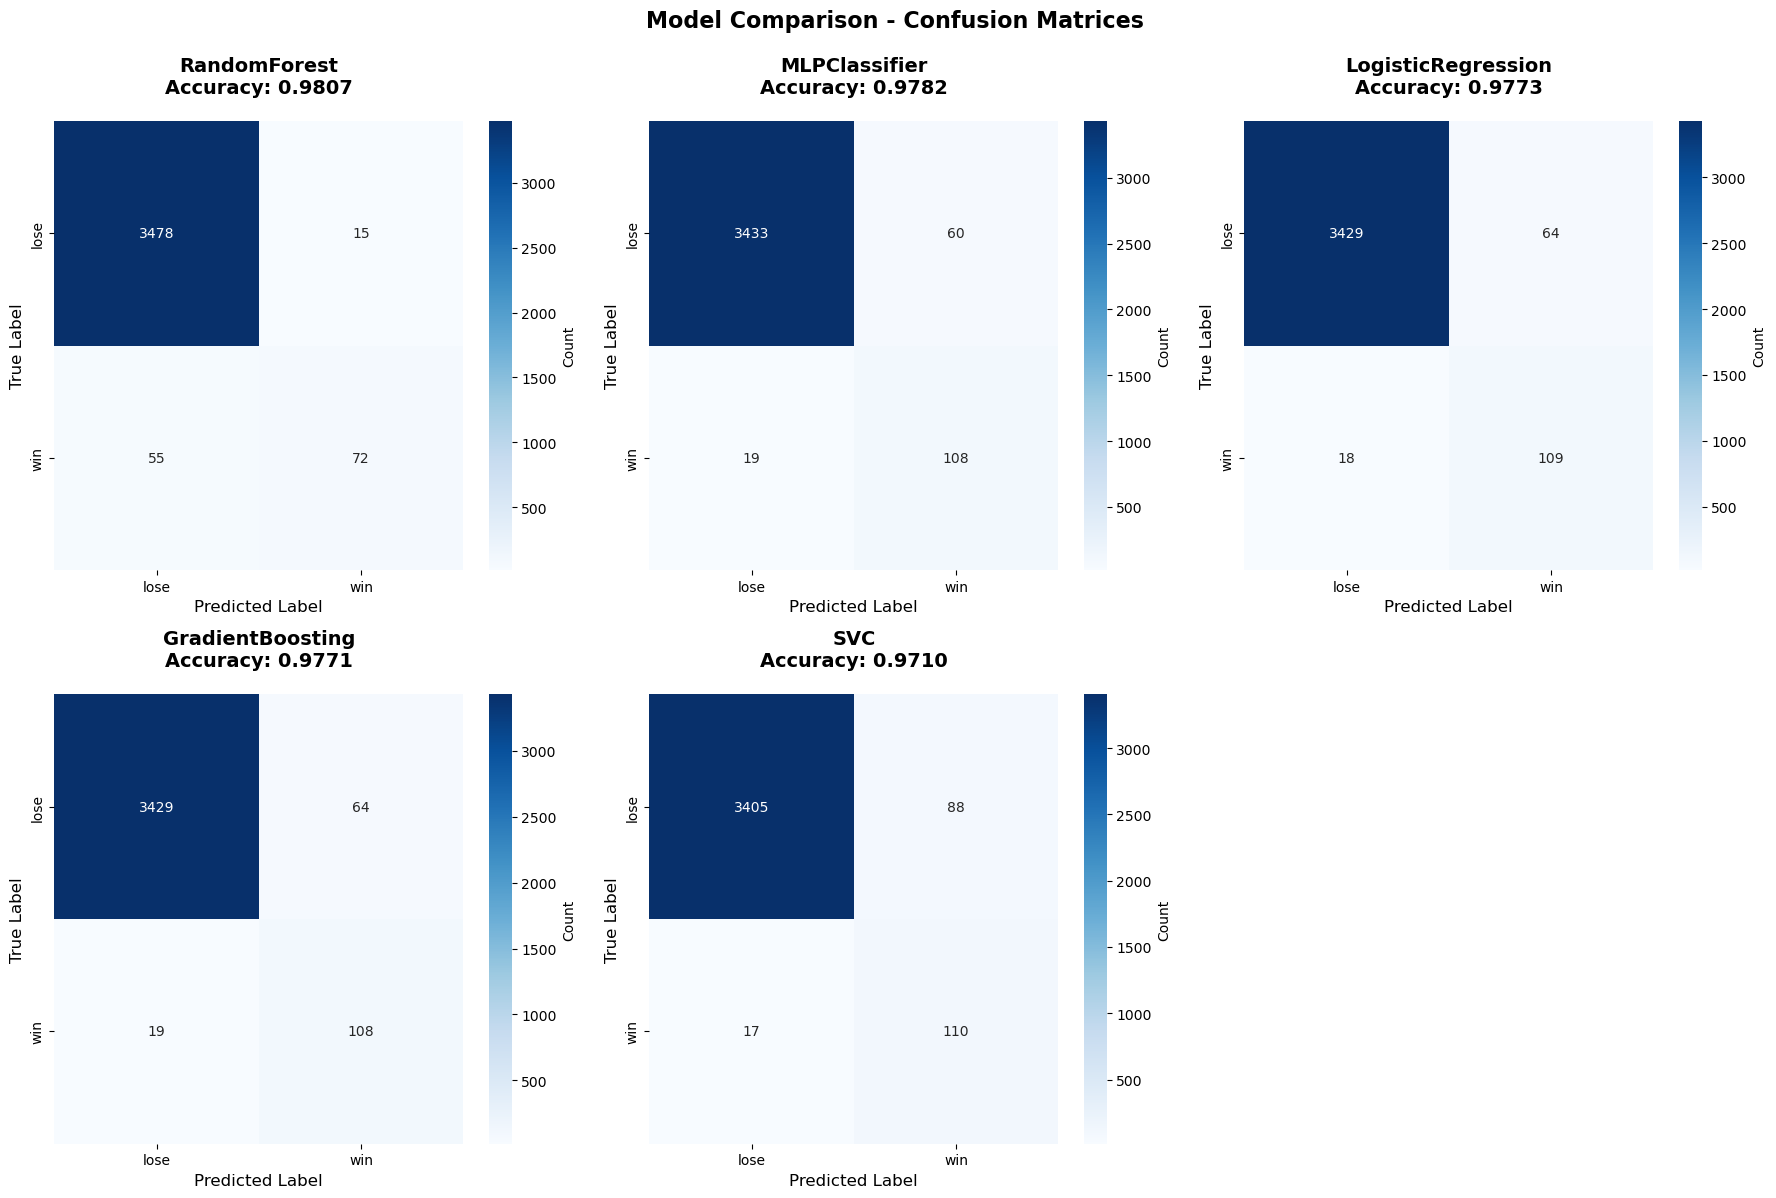


Model Performance Comparison:
             Model Accuracy Precision Recall F1-Score  TP  FP  FN   TN
      RandomForest   0.9807    0.8276 0.5669   0.6729  72  15  55 3478
     MLPClassifier   0.9782    0.6429 0.8504   0.7322 108  60  19 3433
LogisticRegression   0.9773    0.6301 0.8583   0.7267 109  64  18 3429
  GradientBoosting   0.9771    0.6279 0.8504   0.7224 108  64  19 3429
               SVC   0.9710    0.5556 0.8661   0.6769 110  88  17 3405


In [10]:
# Create comparison visualization
print("Model Comparison - Confusion Matrices")
print("=" * 70)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Sort models by accuracy for better visualization
sorted_models = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

for idx, (name, result) in enumerate(sorted_models):
    cm = result['confusion_matrix']
    plot_confusion_matrix(cm, class_names, 
                         f'{name}\nAccuracy: {result["accuracy"]:.4f}',
                         ax=axes[idx], show_percentages=False)

# Remove the last empty subplot
fig.delaxes(axes[5])

plt.suptitle('Model Comparison - Confusion Matrices', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Create comparison table
print("\nModel Performance Comparison:")
print("=" * 70)
comparison_data = []

for name, result in sorted_models:
    cm = result['confusion_matrix']
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = result['accuracy']
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
    
    comparison_data.append({
        'Model': name,
        'Accuracy': f"{accuracy:.4f}",
        'Precision': f"{precision:.4f}",
        'Recall': f"{recall:.4f}",
        'F1-Score': f"{f1_score:.4f}",
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'TN': tn
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))
print("=" * 70)


## 9. Compare All Models


MODEL COMPARISON SUMMARY


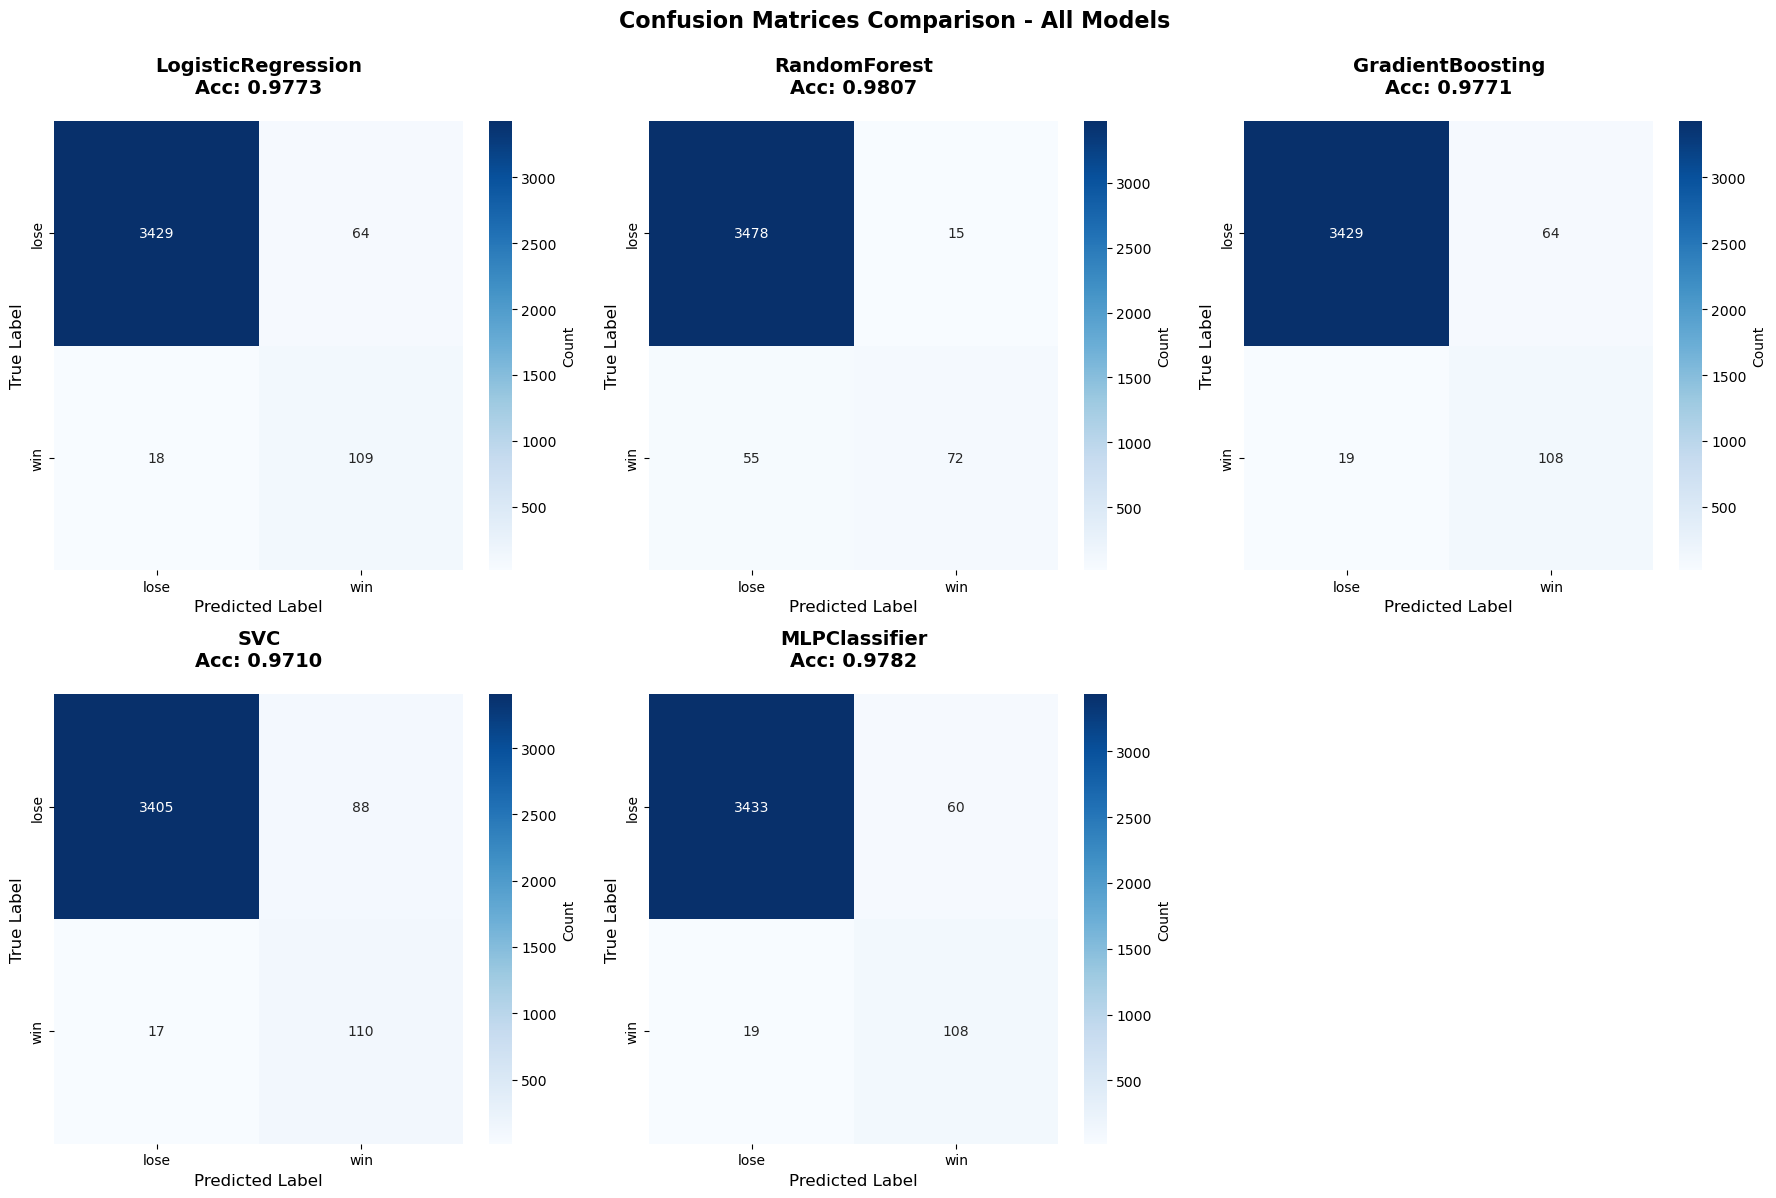


COMPREHENSIVE METRICS COMPARISON


             Model  Accuracy  Precision   Recall  Specificity  F1-Score  TP  FP  FN   TN
      RandomForest  0.980663   0.827586 0.566929     0.995706  0.672897  72  15  55 3478
     MLPClassifier  0.978177   0.642857 0.850394     0.982823  0.732203 108  60  19 3433
LogisticRegression  0.977348   0.630058 0.858268     0.981678  0.726667 109  64  18 3429
  GradientBoosting  0.977072   0.627907 0.850394     0.981678  0.722408 108  64  19 3429
               SVC  0.970994   0.555556 0.866142     0.974807  0.676923 110  88  17 3405



In [11]:
# Create comparison visualization of all models
print("="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)

# Plot all confusion matrices side-by-side
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (name, result) in enumerate(results.items()):
    cm = result['confusion_matrix']
    plot_confusion_matrix(cm, class_names, 
                         f'{name}\nAcc: {result["accuracy"]:.4f}',
                         ax=axes[idx], show_percentages=False)

# Remove the last empty subplot
fig.delaxes(axes[5])

plt.suptitle('Confusion Matrices Comparison - All Models', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Create comparison metrics table
print("\n" + "="*70)
print("COMPREHENSIVE METRICS COMPARISON")
print("="*70)

comparison_data = []
for name, result in results.items():
    cm = result['confusion_matrix']
    tn, fp, fn, tp = cm.ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1_score = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
    
    comparison_data.append({
        'Model': name,
        'Accuracy': result['accuracy'],
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1-Score': f1_score,
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'TN': tn
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Accuracy', ascending=False)

print("\n")
print(comparison_df.to_string(index=False))
print("\n" + "="*70)


## 10. Select Best Model



BEST MODEL SELECTION (Based on F1-Score)

Selected Model: MLPClassifier

Performance Metrics:
  F1-Score:  0.7322 (73.22%)
  Accuracy:  0.9782 (97.82%)
  Precision: 0.6429 (64.29%)
  Recall:    0.8504 (85.04%)

Note: F1-Score selected as primary metric to balance precision and recall
      This is optimal for identifying winnable appeal cases.


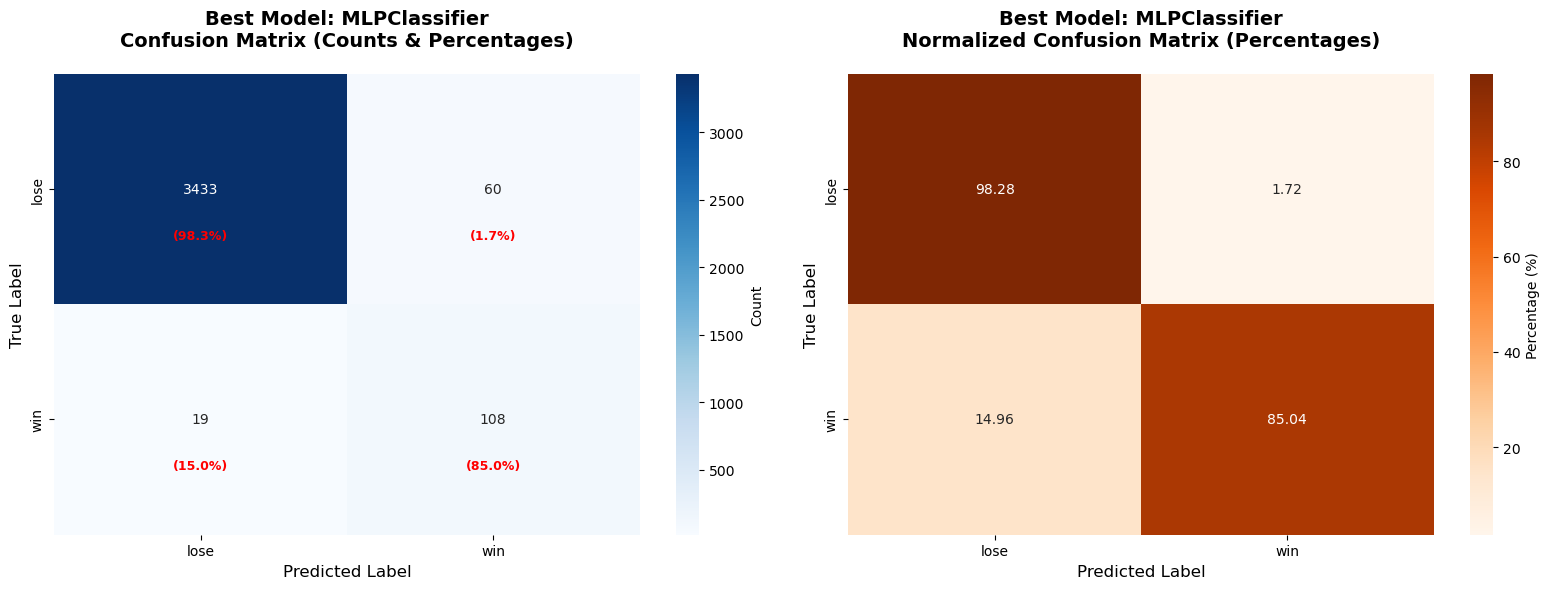


BEST MODEL: MLPClassifier - Detailed Metrics

Confusion Matrix:
  True Negatives (TN):  3433  - Correctly predicted 'lose'
  False Positives (FP):   60  - Predicted 'win' but actually 'lose'
  False Negatives (FN):   19  - Predicted 'lose' but actually 'win'
  True Positives (TP):   108  - Correctly predicted 'win'

Performance Metrics:
  Accuracy:     0.9782 (97.82%)
  Precision:    0.6429 (64.29%)
  Recall:       0.8504 (85.04%)
  Specificity:  0.9828 (98.28%)
  F1-Score:    0.7322




In [12]:
# Find best model based on F1-Score (better metric for imbalanced data)
# F1-Score balances precision and recall, which is crucial for identifying winnable cases
best_model_name = max(results, key=lambda x: results[x]['f1_score'])
best_model = results[best_model_name]['model']
best_accuracy = results[best_model_name]['accuracy']
best_precision = results[best_model_name]['precision']
best_recall = results[best_model_name]['recall']
best_f1_score = results[best_model_name]['f1_score']
best_cm = results[best_model_name]['confusion_matrix']

print(f"\n{'='*70}")
print(f"BEST MODEL SELECTION (Based on F1-Score)")
print(f"{'='*70}")
print(f"\nSelected Model: {best_model_name}")
print(f"\nPerformance Metrics:")
print(f"  F1-Score:  {best_f1_score:.4f} ({best_f1_score*100:.2f}%)")
print(f"  Accuracy:  {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"  Precision: {best_precision:.4f} ({best_precision*100:.2f}%)")
print(f"  Recall:    {best_recall:.4f} ({best_recall*100:.2f}%)")
print(f"\nNote: F1-Score selected as primary metric to balance precision and recall")
print(f"      This is optimal for identifying winnable appeal cases.")

# Detailed visualization of best model
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Confusion Matrix with counts and percentages
plot_confusion_matrix(best_cm, class_names, 
                     f'Best Model: {best_model_name}\nConfusion Matrix (Counts & Percentages)',
                     ax=axes[0])

# Plot 2: Normalized Confusion Matrix (percentages only)
cm_normalized = best_cm.astype('float') / best_cm.sum(axis=1)[:, np.newaxis] * 100

sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Oranges',
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[1], cbar_kws={'label': 'Percentage (%)'})

axes[1].set_title(f'Best Model: {best_model_name}\nNormalized Confusion Matrix (Percentages)',
                fontsize=14, fontweight='bold', pad=20)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylim(len(class_names), 0)

plt.tight_layout()
plt.show()

# Print final detailed metrics
print_model_metrics(best_cm, class_names, f"BEST MODEL: {best_model_name}")

print(f"\n{'='*70}")


## 11. Save Best Model and Artifacts


In [13]:
# Save model
with open(MODELS_DIR / 'model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save label encoder
with open(MODELS_DIR / 'label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Save embeddings
np.save(MODELS_DIR / 'embeddings.npy', embeddings)

# Save clean dataset
df.to_csv(MODELS_DIR / 'clean_dataset.csv', index=False)

# Save model comparison results
comparison_df.to_csv(MODELS_DIR / 'model_comparison.csv', index=False)

# Save best model confusion matrix
np.save(MODELS_DIR / 'best_model_confusion_matrix.npy', best_cm)

print(f"\n{'='*70}")
print(f"MODEL ARTIFACTS SAVED")
print(f"{'='*70}")
print(f"\nSaved to: {MODELS_DIR}")
print(f"\nSaved files:")
print(f"  ✓ model.pkl (Best model: {best_model_name})")
print(f"  ✓ label_encoder.pkl")
print(f"  ✓ embeddings.npy")
print(f"  ✓ clean_dataset.csv")
print(f"  ✓ model_comparison.csv")
print(f"  ✓ best_model_confusion_matrix.npy")
print(f"\n{'='*70}")
print(f"\nModel Training Pipeline Complete! ✓")
print(f"{'='*70}")



MODEL ARTIFACTS SAVED

Saved to: ../models

Saved files:
  ✓ model.pkl (Best model: MLPClassifier)
  ✓ label_encoder.pkl
  ✓ embeddings.npy
  ✓ clean_dataset.csv
  ✓ model_comparison.csv
  ✓ best_model_confusion_matrix.npy


Model Training Pipeline Complete! ✓
